# Price simulation - TensorFlow

Source: https://ipythonquant.wordpress.com/2018/05/22/tensorflow-meets-quantitative-finance-pricing-exotic-options-with-monte-carlo-simulations-in-tensorflow/

In [1]:
import numpy as np
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

/Users/mbenyo/Virtualenvs/ml_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def blackScholes_py(S_0, strike, time_to_expiry, implied_vol, riskfree_rate):
    S = S_0
    K = strike
    dt = time_to_expiry
    sigma = implied_vol
    r = riskfree_rate
    Phi = stats.norm.cdf
    d_1 = (np.log(S_0 / K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d_2 = d_1 - sigma*np.sqrt(dt)
    return S*Phi(d_1) - K*np.exp(-r*dt)*Phi(d_2)
 
blackScholes_py(100., 110., 2., 0.2, 0.03)

9.73983632580859

In [3]:
def blackScholes_tf_pricer(enable_greeks = True):
    # Build the static computational graph
    S = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    Phi = tf.distributions.Normal(0.,1.).cdf
    d_1 = (tf.log(S / K) + (r+sigma**2/2)*dt) / (sigma*tf.sqrt(dt))
    d_2 = d_1 - sigma*tf.sqrt(dt)
    npv =  S*Phi(d_1) - K*tf.exp(-r*dt)*Phi(d_2)
    target_calc = [npv]
    if enable_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, dt])
        dS_2ndOrder = tf.gradients(greeks[0], [S, sigma, r, K, dt]) 
        # Calculate mixed 2nd order greeks for S (esp. gamma, vanna) and sigma (esp. volga)
        dsigma_2ndOrder = tf.gradients(greeks[1], [S, sigma, r, K, dt])
        dr_2ndOrder = tf.gradients(greeks[2], [S, sigma, r, K, dt]) 
        dK_2ndOrder = tf.gradients(greeks[3], [S, sigma, r, K, dt]) 
        dT_2ndOrder = tf.gradients(greeks[4], [S, sigma, r, K, dt])
        target_calc += [greeks, dS_2ndOrder, dsigma_2ndOrder, dr_2ndOrder, dK_2ndOrder, dT_2ndOrder]
     
    # Function to feed in the input and calculate the computational graph
    def execute_graph(S_0, strike, time_to_expiry, implied_vol, riskfree_rate):
        with tf.Session() as sess:
            res = sess.run(target_calc, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt: time_to_expiry})
        return res
    return execute_graph
 
tf_pricer = blackScholes_tf_pricer()
tf_pricer(100., 110., 2., 0.2, 0.03)

[9.739834,
 [0.5066145, 56.411205, 81.843216, -0.37201464, 4.0482087],
 [0.014102802, 0.5310427, 2.8205605, -0.012820729, 0.068860546],
 [0.5310427, -1.2452297, -6.613867, 0.030063031, 13.941332],
 [2.8205605, -6.613866, 400.42563, -1.8201164, 46.5973],
 [-0.012820728, 0.030063028, -1.8201163, 0.011655207, -0.025798593],
 [0.06886053, 13.941331, 46.597298, -0.025798589, -0.62807804]]

In [4]:
def create_tf_graph_for_simulate_paths():
    S = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    T = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    dw = tf.placeholder(tf.float32)
    S_T = S * tf.cumprod(tf.exp((r-sigma**2/2)*dt+sigma*tf.sqrt(dt)*dw), axis=1)
    return (S, K, dt, T, sigma, r, dw, S_T)

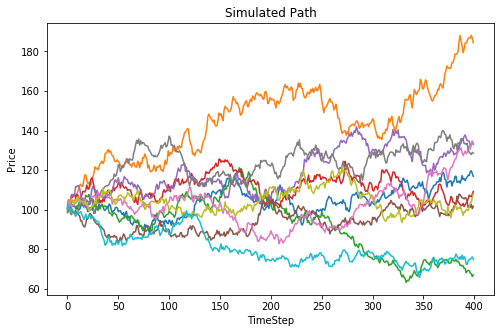

In [5]:
def make_path_simulator():
    (S,K, dt, T, sigma, r, dw, S_T) = create_tf_graph_for_simulate_paths()
    def paths(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, seed, n_sims, obs):
        if seed != 0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, obs)
        with tf.Session() as sess:
            timedelta = time_to_expiry / stdnorm_random_variates.shape[1]
            res = sess.run(S_T, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt : timedelta,
                               T: time_to_expiry,
                               dw : stdnorm_random_variates
                         })
            return res
    return paths
 
path_simulator = make_path_simulator()
paths = path_simulator(100, 110.,  2, 0.2, 0.03, 1312, 10, 400)
plt.figure(figsize=(8,5))
_= plt.plot(np.transpose(paths))
_ = plt.title('Simulated Path')
_ = plt.ylabel('Price')
_ = plt.xlabel('TimeStep') 